In [42]:
# import packages
import os
import joblib
import numpy as np
import pandas as pd
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

#for model building
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

import warnings as wr
wr.filterwarnings("ignore") #to ignore the warnings

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import lightgbm
from lightgbm import LGBMRegressor

import pickle 
print(pickle.format_version)

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv
4.0


In [59]:
df=pd.read_csv("../input/heart-attack-analysis-prediction-dataset/heart.csv")
df.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1


In [60]:
x = df.drop(["output"],axis=1)
y = df["output"]

In [61]:
scalerX = StandardScaler()
X[x.columns] = scalerX.fit_transform(x[x.columns])

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

In [63]:
ada=AdaBoostClassifier()
ada.fit(x_train,y_train)
ada_pre=ada.predict(X_test)
acc_ada = accuracy_score(y_test,ada_pre)
acc_ada

0.36065573770491804

In [67]:
key = ['AdaBoostClassifier','LogisticRegression','KNeighborsClassifier','SVC','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','XGBClassifier']
value = [AdaBoostClassifier(),LogisticRegression(random_state=9), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators = 100, random_state = 0), GradientBoostingClassifier(), xgb.XGBClassifier()]
models = dict(zip(key,value))

In [65]:
model =[]

In [71]:
for name,algo in models.items():
    model=algo
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    acc = accuracy_score(y_test, predict)
    #conf = confusion_matrix(y_test, predicted)
    print(confusion_matrix(y_test, predicted))
    #model.append((acc,conf))
    print(name,acc)

ValueError: Found input variables with inconsistent numbers of samples: [61, 8]

<AxesSubplot:>

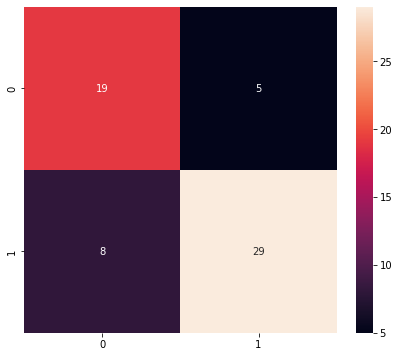

In [39]:
#confusion matrix
cnn=KNeighborsClassifier()
cnn.fit(X_train,y_train)
cnn_predict = cnn.predict(X_test)
cf_matrix=confusion_matrix(y_test,cnn_predict)
plt.figure(figsize=(7,6))
sns.heatmap(cf_matrix,annot=True,fmt='d')

<AxesSubplot:>

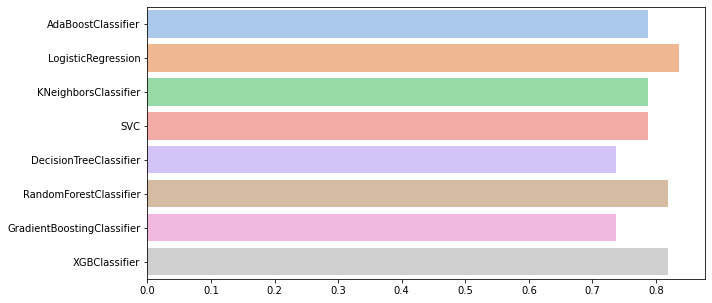

In [40]:
plt.figure(figsize = (10,5))
sns.barplot(x = predicted, y = key, palette='pastel')

# Model training

In [7]:
%%time

seed = 0
folds = 10
models = []

skf = StratifiedKFold(folds, shuffle = True, random_state = seed)

for train_index, test_index in skf.split(train_df, train_df['investment_id']):
    train = train_df.iloc[train_index]
    valid = train_df.iloc[test_index]
    
    lgbm = LGBMRegressor(
        num_leaves=2 ** np.random.randint(3, 8),
        learning_rate = 10 ** (-np.random.uniform(0.1,2)),
        n_estimators = 10,
        min_child_samples = 1000, 
        subsample=np.random.uniform(0.5,1.0), 
        subsample_freq=1,
        n_jobs= -1#,device='gpu'
    )

    lgbm.fit(train[features], train[target], eval_set = (valid[features], valid[target]), early_stopping_rounds = 10)
    models.append(lgbm)

NameError: name 'train_df' is not defined

In [8]:
%%time

lightgbm.plot_importance(lgbm, figsize = (20, 60))

NameError: name 'lgbm' is not defined

In [9]:
%%time


for (test_df, sample_prediction_df) in iter_test:
    
    test_df['target']  = 0
    
    for lgbm in models:
        test_df['target'] += lgbm.predict(test_df[features])
    test_df['target'] /= len(models)
    env.predict(test_df[['row_id','target']])

NameError: name 'ubiquant' is not defined